In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os

### Convolutional autoencoder

In [ ]:
from keras.layers import *
from keras.models import *
from tensorflow import keras

### Sampling layers

In [ ]:
def Sampling(z_mean, z_log_var):
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape = (batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Encoder part

In [ ]:
latent_dim = 2

inputs = keras.Input(shape=(28, 28, 1))
x = Conv2D(32, 3, strides=1, padding="same", kernel_initializer="he_normal")(inputs)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Conv2D(64, 3, strides=2, padding="same", kernel_initializer="he_normal")(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Conv2D(128, 3, strides=2, padding="same", kernel_initializer="he_normal")(x)
x = LeakyReLU(0.2)(x)

x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

x = tf.keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal")(x)
z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean", kernel_initializer="he_normal")(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name = "z_log_var", kernel_initializer="he_normal")(x)

z = Sampling(z_mean, z_log_var)
encoder_part = keras.Model(inputs, [z_mean, z_log_var, z])
encoder_part.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 28, 28, 32)   0           ['batch_normalization[0][0]']

### Decoder part

In [ ]:
input = Input(shape=(latent_dim, ))
x = Dense(7*7*128, activation="relu", kernel_initializer="he_normal")(input)
x = Reshape((7, 7, 128))(x)

x = Conv2DTranspose(64, kernel_size=(3, 3), strides=2, kernel_initializer="he_normal", padding ="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

x = Conv2DTranspose(32, kernel_size=(3, 3), strides=2, kernel_initializer="he_normal", padding ="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.2)(x)

output = Conv2D(1, kernel_size=(3, 3),activation = "sigmoid", kernel_initializer="he_normal", padding ="same")(x)

decoder_part = Model(inputs = input, outputs = output)
decoder_part.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 6272)              18816     
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       73792     
 nspose)                                                         
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0   

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

### Train data

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
callbacks = [ReduceLROnPlateau(monitor="loss", factor=0.1, patience=15, min_lr=0.0000001), ]

In [ ]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train/255.0
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
vae = VAE(encoder_part, decoder_part)
vae.compile(optimizer=keras.optimizers.Adam(lr =0.0001))
vae.fit(x_train, epochs=200, batch_size=256, callbacks= callbacks)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/200
235/235 [==============================] - 24s 31ms/step - loss: 428.0163 - reconstruction_loss: 312.7937 - kl_loss: 5.0271 - lr: 1.0000e-04
Epoch 2/200
235/235 [==============================] - 7s 30ms/step - loss: 213.2744 - reconstruction_loss: 203.7989 - kl_loss: 7.0436 - lr: 1.0000e-04
Epoch 3/200
235/235 [==============================] - 7s 30ms/step - loss: 205.0837 - reconstruction_loss: 197.4525 - kl_loss: 5.9462 - lr: 1.0000e-04
Epoch 4/200
235/235 [==============================] - 7s 30ms/step - loss: 199.5541 - reconstruction_loss: 193.5356 - kl_loss: 5.3720 - lr: 1.0000e-04
Epoch 5/200
235/235 [==============================] - 7s 30ms/step - loss: 196.7040 - reconstruction_loss: 191.0336 - kl_loss: 5.0803 - lr: 1.0000e-04
Epoch 6/200
235/235 [==============================] - 7s 30ms/step - loss: 194.7720 - reconstruction_loss: 189.3990 - kl_loss: 4.9396 - lr: 1.0000e-04
Epoch 7/200
235/235 [==============================] - 7s 31ms/step - loss: 193.4495 - 

KeyboardInterrupt: ignored

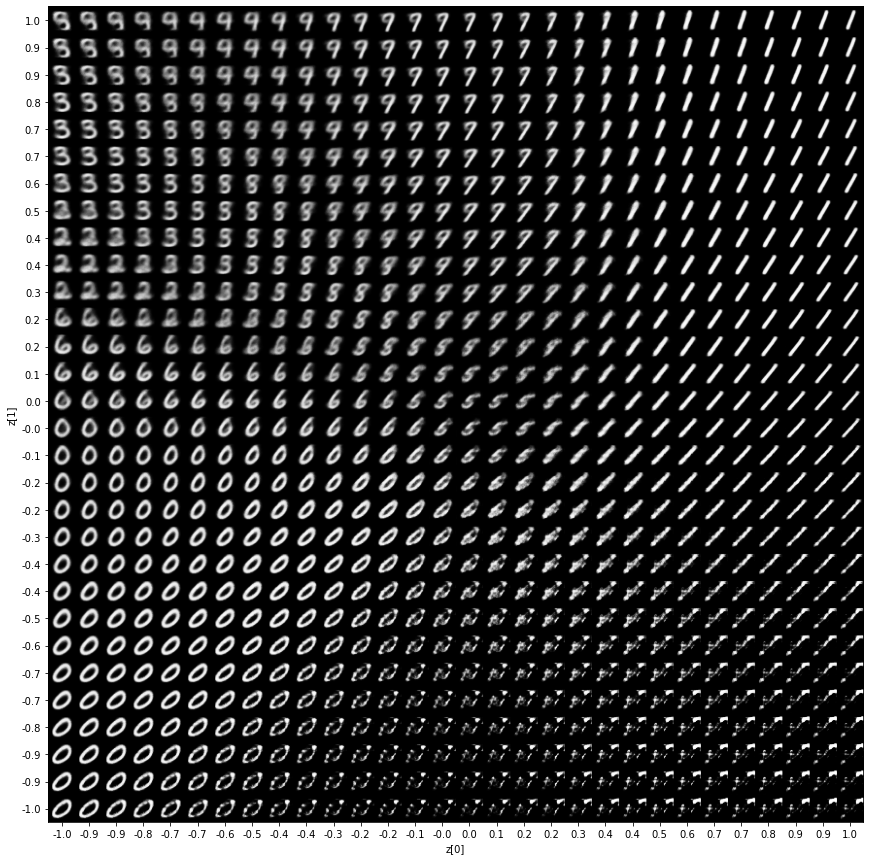

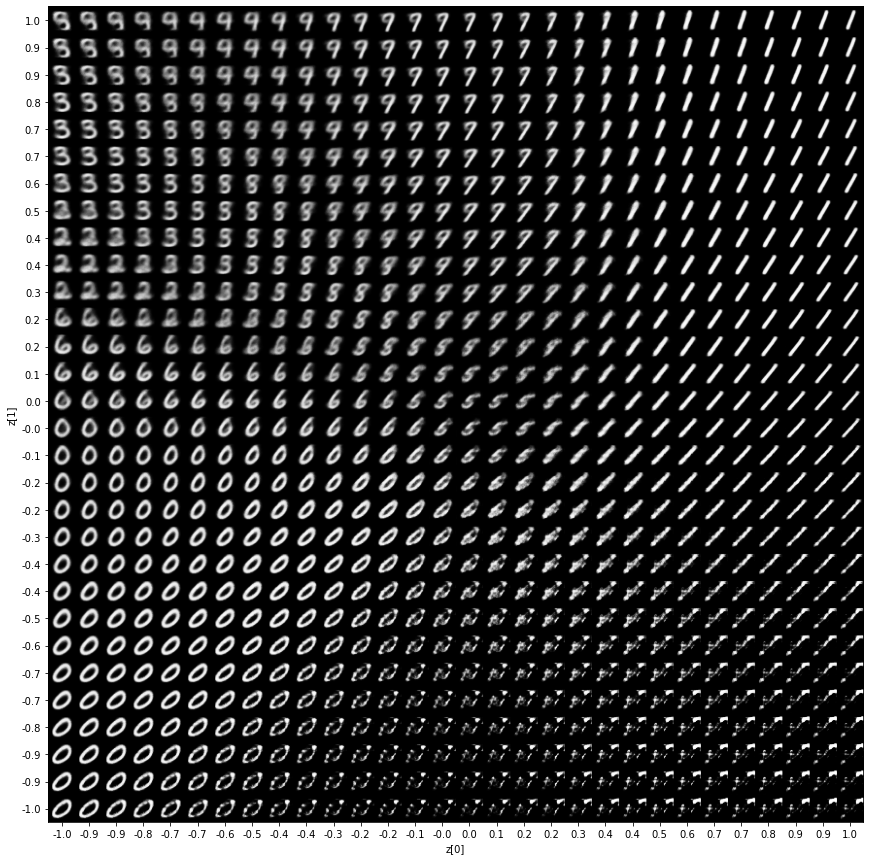

In [ ]:
import matplotlib.pyplot as plt
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(vae)

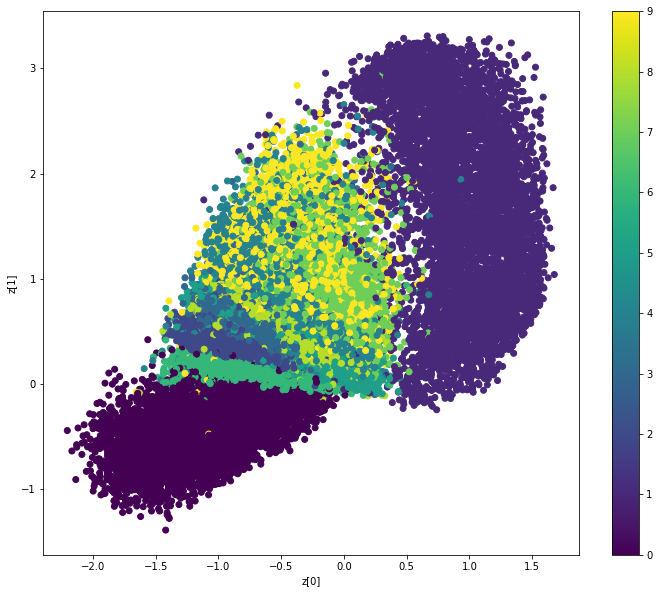

In [ ]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255


z_mean, _, _ = vae.encoder.predict(x_train)
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_train)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()